# Chapter 9: GTSAM과의 비교 및 통합

## 🎯 학습 목표

이 챕터에서는 널리 사용되는 SLAM 라이브러리인 GTSAM(Georgia Tech Smoothing and Mapping)을 배우고, 우리가 구현한 nano-pgo와 비교해봅니다.

- GTSAM의 핵심 개념 이해
- Factor Graph 기반 최적화
- nano-pgo vs GTSAM 성능 비교
- 실제 프로젝트에서의 선택 기준

## 📚 GTSAM 소개

GTSAM은 조지아텍에서 개발한 C++ 라이브러리로, 다음과 같은 특징을 가집니다:

1. **Factor Graph 추상화**: 문제를 factor와 variable로 표현
2. **다양한 최적화 알고리즘**: Gauss-Newton, Levenberg-Marquardt, Dogleg
3. **Incremental 최적화**: iSAM2 알고리즘 지원
4. **풍부한 Factor 라이브러리**: PriorFactor, BetweenFactor, 등

## 🔧 GTSAM 설치 및 기본 사용법

주의: 이 노트북은 GTSAM이 이미 설치되어 있다고 가정합니다.
설치되지 않은 경우, 다음 명령어로 설치할 수 있습니다:
```bash
pip install gtsam
```

In [1]:
# GTSAM import 시도
try:
    import gtsam
    import gtsam.utils.plot as gtsam_plot
    from gtsam import Pose3, Rot3, Point3
    GTSAM_AVAILABLE = True
    print("✅ GTSAM이 성공적으로 임포트되었습니다!")
    # print(f"GTSAM 버전: {gtsam.__version__}")
except ImportError:
    GTSAM_AVAILABLE = False
    print("⚠️ GTSAM이 설치되어 있지 않습니다.")
    print("이 챕터는 GTSAM의 개념과 사용법을 설명하는 데 중점을 둡니다.")

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

✅ GTSAM이 성공적으로 임포트되었습니다!


## 1. GTSAM의 Factor Graph 개념

In [2]:
if GTSAM_AVAILABLE:
    # GTSAM으로 간단한 pose graph 만들기
    
    # 1. Factor Graph와 초기 추정치 생성
    graph = gtsam.NonlinearFactorGraph()
    initial_estimate = gtsam.Values()
    
    # 2. Prior Factor 추가 (첫 번째 포즈 고정)
    prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))
    graph.add(gtsam.PriorFactorPose3(0, Pose3(), prior_noise))
    
    # 3. 초기 포즈들 추가
    poses = [
        Pose3(),  # 원점
        Pose3(Rot3(), Point3(1, 0, 0)),  # x로 1m 이동
        Pose3(Rot3(), Point3(2, 0, 0)),  # x로 2m 이동
        Pose3(Rot3.Rz(np.pi/2), Point3(2, 1, 0)),  # 회전 후 이동
    ]
    
    for i, pose in enumerate(poses):
        initial_estimate.insert(i, pose)
    
    # 4. Between Factors 추가 (odometry measurements)
    odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.2, 0.1, 0.1, 0.1]))
    
    # 연속적인 포즈들 간의 측정값
    graph.add(gtsam.BetweenFactorPose3(0, 1, 
        Pose3(Rot3(), Point3(1, 0, 0)), odometry_noise))
    graph.add(gtsam.BetweenFactorPose3(1, 2, 
        Pose3(Rot3(), Point3(1, 0, 0)), odometry_noise))
    graph.add(gtsam.BetweenFactorPose3(2, 3, 
        Pose3(Rot3.Rz(np.pi/2), Point3(0, 1, 0)), odometry_noise))
    
    # Loop closure (with larger uncertainty)
    loop_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5, 0.5, 0.3, 0.3, 0.3]))
    graph.add(gtsam.BetweenFactorPose3(3, 0, 
        Pose3(Rot3.Rz(-np.pi/2), Point3(-2, -1, 0)), loop_noise))
    
    print("✅ Factor Graph 생성 완료!")
    print(f"   - Factors 개수: {graph.size()}")
    print(f"   - Variables 개수: {initial_estimate.size()}")
else:
    print("📝 GTSAM Factor Graph 예제:")
    print("""    
    # Factor Graph 생성
    graph = gtsam.NonlinearFactorGraph()
    
    # Prior Factor: 첫 번째 포즈를 원점에 고정
    graph.add(gtsam.PriorFactorPose3(0, Pose3(), prior_noise))
    
    # Between Factor: 포즈 간 상대 측정
    graph.add(gtsam.BetweenFactorPose3(0, 1, measured_transform, noise))
    """)

✅ Factor Graph 생성 완료!
   - Factors 개수: 5
   - Variables 개수: 4


## 2. GTSAM 최적화 실행


✅ 최적화 완료!Initial error: 55.5556
newError: 28.1857
errorThreshold: 28.1857 > 0
absoluteDecrease: 27.3698826362 >= 1e-05
relativeDecrease: 0.492657887452 >= 1e-05
newError: 22.1536146186
errorThreshold: 22.1536146186 > 0
absoluteDecrease: 6.03205830078 >= 1e-05
relativeDecrease: 0.214011505705 >= 1e-05
newError: 20.4932272307
errorThreshold: 20.4932272307 > 0
absoluteDecrease: 1.66038738784 >= 1e-05
relativeDecrease: 0.0749488251208 >= 1e-05
newError: 20.3340962698
errorThreshold: 20.3340962698 > 0
absoluteDecrease: 0.159130960883 >= 1e-05
relativeDecrease: 0.00776505130654 >= 1e-05
newError: 20.3300544405
errorThreshold: 20.3300544405 > 0
absoluteDecrease: 0.00404182934177 >= 1e-05
relativeDecrease: 0.000198771034037 >= 1e-05
newError: 20.3300544405
errorThreshold: 20.3300544405 > 0
absoluteDecrease: 0 < 1e-05
relativeDecrease: 0 < 1e-05
converged
errorThreshold: 20.3300544405 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 5 >? 100

   - 초기 에러: 55.5556
   - 

/tmp/ipykernel_97368/173977679.py:52: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/173977679.py:52: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/173977679.py:52: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/173977679.py:52: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/173977679.py:52: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/user1/ROS2_Workspace/Symforce_ws/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user1/ROS2_Workspace/Symforce_ws/.venv/l

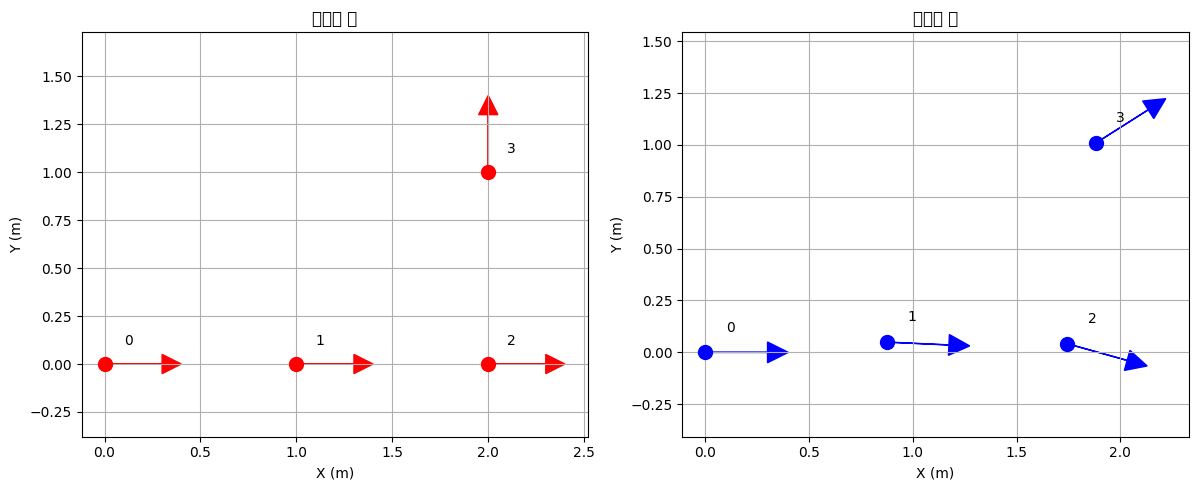

In [3]:
if GTSAM_AVAILABLE:
    # Levenberg-Marquardt 최적화
    params = gtsam.LevenbergMarquardtParams()
    params.setVerbosity('ERROR')  # 출력 레벨 설정
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
    
    # 최적화 실행
    result = optimizer.optimize()
    
    print("\n✅ 최적화 완료!")
    print(f"   - 초기 에러: {graph.error(initial_estimate):.4f}")
    print(f"   - 최종 에러: {graph.error(result):.4f}")
    print(f"   - 반복 횟수: {optimizer.iterations()}")
    
    # 결과 시각화
    fig = plt.figure(figsize=(12, 5))
    
    # 최적화 전
    ax1 = fig.add_subplot(121)
    ax1.set_title("최적화 전")
    for i in range(initial_estimate.size()):
        pose = initial_estimate.atPose3(i)
        x, y = pose.x(), pose.y()
        ax1.plot(x, y, 'ro', markersize=10)
        ax1.text(x+0.1, y+0.1, f'{i}')
        
        # 방향 표시
        yaw = pose.rotation().yaw()
        dx, dy = 0.3 * np.cos(yaw), 0.3 * np.sin(yaw)
        ax1.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='r', ec='r')
    
    # 최적화 후
    ax2 = fig.add_subplot(122)
    ax2.set_title("최적화 후")
    for i in range(result.size()):
        pose = result.atPose3(i)
        x, y = pose.x(), pose.y()
        ax2.plot(x, y, 'bo', markersize=10)
        ax2.text(x+0.1, y+0.1, f'{i}')
        
        # 방향 표시
        yaw = pose.rotation().yaw()
        dx, dy = 0.3 * np.cos(yaw), 0.3 * np.sin(yaw)
        ax2.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='b', ec='b')
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("📝 GTSAM 최적화 과정:")
    print("""    
    # Levenberg-Marquardt 최적화 설정
    params = gtsam.LevenbergMarquardtParams()
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
    
    # 최적화 실행
    result = optimizer.optimize()
    
    # Gauss-Newton도 사용 가능
    gn_params = gtsam.GaussNewtonParams()
    gn_optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, gn_params)
    """)

## 3. nano-pgo vs GTSAM 비교

In [4]:
# nano-pgo 스타일 구현 (간단한 버전)
class NanoPGOOptimizer:
    def __init__(self):
        self.poses = []
        self.edges = []
    
    def add_pose(self, pose):
        self.poses.append(pose)
    
    def add_edge(self, i, j, measurement, information):
        self.edges.append((i, j, measurement, information))
    
    def optimize(self, iterations=10):
        # 간단한 Gauss-Newton 구현
        for iter in range(iterations):
            # H 행렬과 b 벡터 구성
            n = len(self.poses)
            H = np.zeros((n*6, n*6))
            b = np.zeros(n*6)
            
            # ... (실제 구현은 Chapter 4 참조)
            
        return self.poses

print("📊 nano-pgo vs GTSAM 비교:\n")

comparison_table = """
| 특징 | nano-pgo | GTSAM |
|------|----------|-------|
| 언어 | Python | C++ (Python 바인딩) |
| 설치 | pip 불필요 | pip install gtsam |
| 의존성 | NumPy, SciPy | Eigen, Boost |
| 최적화 알고리즘 | Gauss-Newton | GN, LM, Dogleg |
| Factor 종류 | Between | Prior, Between, 등 다양 |
| Incremental | 미지원 | iSAM2 지원 |
| 학습 목적 | 최적 | 좋음 |
| 실제 사용 | 프로토타입 | 프로덕션 |
| 성능 | 보통 | 매우 빠름 |
| 문서화 | 튜토리얼 | 풍부한 문서 |
"""

print(comparison_table)

📊 nano-pgo vs GTSAM 비교:


| 특징 | nano-pgo | GTSAM |
|------|----------|-------|
| 언어 | Python | C++ (Python 바인딩) |
| 설치 | pip 불필요 | pip install gtsam |
| 의존성 | NumPy, SciPy | Eigen, Boost |
| 최적화 알고리즘 | Gauss-Newton | GN, LM, Dogleg |
| Factor 종류 | Between | Prior, Between, 등 다양 |
| Incremental | 미지원 | iSAM2 지원 |
| 학습 목적 | 최적 | 좋음 |
| 실제 사용 | 프로토타입 | 프로덕션 |
| 성능 | 보통 | 매우 빠름 |
| 문서화 | 튜토리얼 | 풍부한 문서 |



## 4. GTSAM의 고급 기능들

In [5]:
if GTSAM_AVAILABLE:
    print("🚀 GTSAM의 고급 기능들:\n")
    
    # 1. iSAM2 (Incremental Smoothing and Mapping)
    print("1. iSAM2 - Incremental 최적화:")
    isam = gtsam.ISAM2()
    print("   - 새로운 측정값이 들어올 때마다 효율적으로 업데이트")
    print("   - 전체 그래프를 다시 최적화하지 않음")
    print("   - 실시간 SLAM에 적합\n")
    
    # 2. Marginal Covariance
    print("2. Marginal Covariance 계산:")
    marginals = gtsam.Marginals(graph, result)
    cov = marginals.marginalCovariance(0)  # 포즈 0의 공분산
    print(f"   - 포즈 0의 불확실성 (대각선 원소): {np.diag(cov)}\n")
    
    # 3. Factor 종류
    print("3. 다양한 Factor 종류:")
    print("   - PriorFactor: 절대 위치 제약")
    print("   - BetweenFactor: 상대 포즈 제약")
    print("   - RangeFactor: 거리 측정")
    print("   - BearingFactor: 방향 측정")
    print("   - IMUFactor: IMU 통합")
    print("   - GPSFactor: GPS 측정\n")
    
else:
    print("📝 GTSAM 고급 기능 예제:")
    print("""    
    # iSAM2 사용 예제
    isam_params = gtsam.ISAM2Params()
    isam_params.relinearizeThreshold = 0.1
    isam = gtsam.ISAM2(isam_params)
    
    # 새로운 측정값 추가
    new_factors = gtsam.NonlinearFactorGraph()
    new_values = gtsam.Values()
    # ... add factors and values ...
    isam.update(new_factors, new_values)
    
    # 공분산 계산
    marginals = gtsam.Marginals(graph, result)
    cov = marginals.marginalCovariance(variable_key)
    """)

🚀 GTSAM의 고급 기능들:

1. iSAM2 - Incremental 최적화:
   - 새로운 측정값이 들어올 때마다 효율적으로 업데이트
   - 전체 그래프를 다시 최적화하지 않음
   - 실시간 SLAM에 적합

2. Marginal Covariance 계산:
   - 포즈 0의 불확실성 (대각선 원소): [0.01 0.01 0.01 0.01 0.01 0.01]

3. 다양한 Factor 종류:
   - PriorFactor: 절대 위치 제약
   - BetweenFactor: 상대 포즈 제약
   - RangeFactor: 거리 측정
   - BearingFactor: 방향 측정
   - IMUFactor: IMU 통합
   - GPSFactor: GPS 측정



## 5. 실제 사용 시나리오

In [6]:
print("🎯 언제 어떤 도구를 사용해야 할까?\n")

scenarios = {
    "학습/교육 목적": {
        "추천": "nano-pgo",
        "이유": "내부 동작을 완전히 이해할 수 있음, 수정이 쉬움"
    },
    "연구 프로토타입": {
        "추천": "SymForce + nano-pgo",
        "이유": "빠른 개발, 심볼릭 미분으로 새로운 factor 쉽게 추가"
    },
    "실시간 로봇 응용": {
        "추천": "GTSAM",
        "이유": "최적화된 C++ 구현, iSAM2로 증분 업데이트 가능"
    },
    "대규모 오프라인 최적화": {
        "추천": "GTSAM 또는 g2o",
        "이유": "메모리 효율적, 병렬화 지원"
    },
    "센서 융합 (IMU/GPS)": {
        "추천": "GTSAM",
        "이유": "이미 구현된 IMU/GPS factors 제공"
    }
}

for scenario, info in scenarios.items():
    print(f"📌 {scenario}:")
    print(f"   추천: {info['추천']}")
    print(f"   이유: {info['이유']}\n")

🎯 언제 어떤 도구를 사용해야 할까?

📌 학습/교육 목적:
   추천: nano-pgo
   이유: 내부 동작을 완전히 이해할 수 있음, 수정이 쉬움

📌 연구 프로토타입:
   추천: SymForce + nano-pgo
   이유: 빠른 개발, 심볼릭 미분으로 새로운 factor 쉽게 추가

📌 실시간 로봇 응용:
   추천: GTSAM
   이유: 최적화된 C++ 구현, iSAM2로 증분 업데이트 가능

📌 대규모 오프라인 최적화:
   추천: GTSAM 또는 g2o
   이유: 메모리 효율적, 병렬화 지원

📌 센서 융합 (IMU/GPS):
   추천: GTSAM
   이유: 이미 구현된 IMU/GPS factors 제공



## 6. GTSAM을 사용한 완전한 예제

Initial error: 282.70994443
newError: 2.5778296548
errorThreshold: 2.5778296548 > 0
absoluteDecrease: 280.132114775 >= 1e-05
relativeDecrease: 0.990881715675 >= 1e-05
newError: 0.10405720785
errorThreshold: 0.10405720785 > 0
absoluteDecrease: 2.47377244695 >= 1e-05
relativeDecrease: 0.959633792071 >= 1e-05
newError: 0.103031230579
errorThreshold: 0.103031230579 > 0
absoluteDecrease: 0.00102597727074 >= 1e-05
relativeDecrease: 0.0098597424622 >= 1e-05
newError: 0.10303072132
errorThreshold: 0.10303072132 > 0
absoluteDecrease: 5.09259947643e-07 < 1e-05
relativeDecrease: 4.94277264067e-06 < 1e-05
converged
errorThreshold: 0.10303072132 <? 0
absoluteDecrease: 5.09259947643e-07 <? 1e-05
relativeDecrease: 4.94277264067e-06 <? 1e-05
iterations: 4 >? 100


/tmp/ipykernel_97368/3114966222.py:115: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/3114966222.py:115: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/3114966222.py:115: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/3114966222.py:115: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/3114966222.py:115: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/3114966222.py:115: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_97368/3114966222.py:115: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  pl

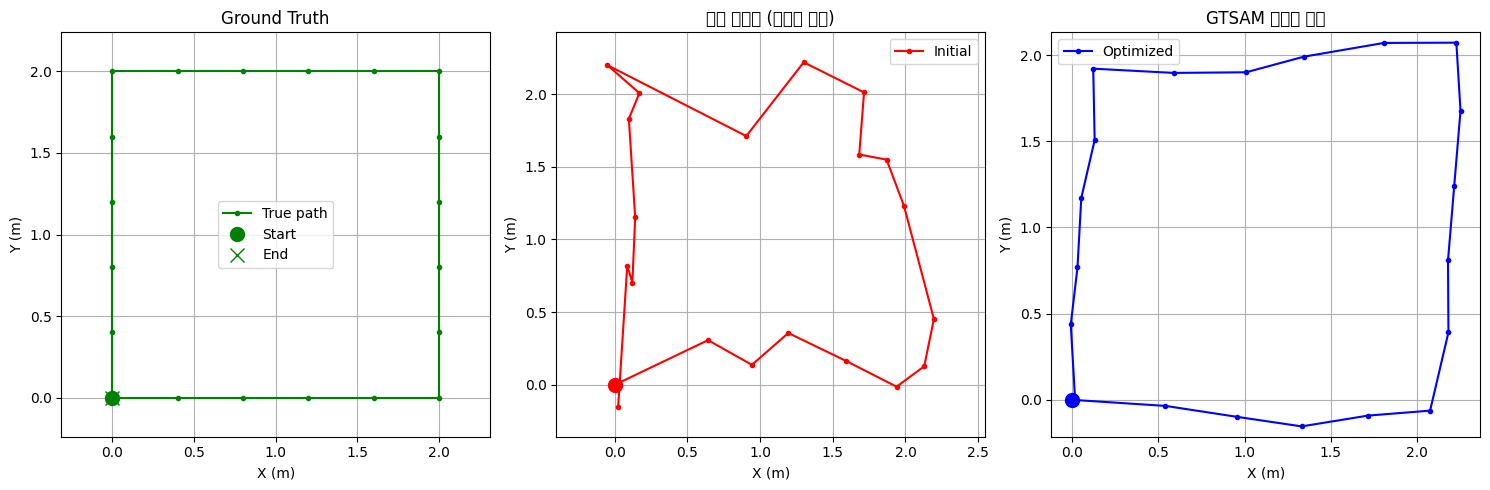


📊 최적화 통계:
   - 포즈 개수: 21
   - Factor 개수: 22
   - 초기 에러: 282.7099
   - 최종 에러: 0.1030
   - 에러 감소율: 100.0%


In [7]:
if GTSAM_AVAILABLE:
    # 실제 SLAM 시나리오 시뮬레이션
    def create_slam_problem():
        """사각형 경로를 따라 이동하는 로봇 시뮬레이션"""
        graph = gtsam.NonlinearFactorGraph()
        initial = gtsam.Values()
        
        # 노이즈 모델
        prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1, 0.05, 0.05, 0.05]))
        odom_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1, 0.1, 0.1, 0.1]))
        
        # Prior
        graph.add(gtsam.PriorFactorPose3(0, Pose3(), prior_noise))
        
        # 사각형 경로 생성
        true_poses = []
        pose = Pose3()
        true_poses.append(pose)
        
        # 각 변마다 5개 포즈
        steps_per_side = 5
        step_size = 2.0 / steps_per_side
        
        pose_id = 0
        
        # 4개의 변을 따라 이동
        for side in range(4):
            for step in range(steps_per_side):
                if side == 0:  # +X 방향
                    delta = Pose3(Rot3(), Point3(step_size, 0, 0))
                elif side == 1:  # +Y 방향
                    delta = Pose3(Rot3(), Point3(0, step_size, 0))
                elif side == 2:  # -X 방향
                    delta = Pose3(Rot3(), Point3(-step_size, 0, 0))
                else:  # -Y 방향
                    delta = Pose3(Rot3(), Point3(0, -step_size, 0))
                
                # 실제 포즈 업데이트
                pose = pose.compose(delta)
                true_poses.append(pose)
                
                # Odometry factor 추가 (노이즈 포함)
                measured = delta.compose(
                    Pose3(Rot3.Rodrigues(np.random.normal(0, 0.01, 3)),
                          Point3(np.random.normal(0, 0.05, 3)))
                )
                graph.add(gtsam.BetweenFactorPose3(pose_id, pose_id + 1, measured, odom_noise))
                
                # 초기 추정치 (노이즈 추가)
                noisy_pose = pose.compose(
                    Pose3(Rot3.Rodrigues(np.random.normal(0, 0.1, 3)),
                          Point3(np.random.normal(0, 0.2, 3)))
                )
                initial.insert(pose_id + 1, noisy_pose)
                
                pose_id += 1
        
        # Loop closure
        loop_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.2, 0.2, 0.2, 0.2]))
        measured_loop = true_poses[0].between(true_poses[-1])
        graph.add(gtsam.BetweenFactorPose3(pose_id, 0, measured_loop, loop_noise))
        
        # 첫 번째 포즈 추가
        initial.insert(0, Pose3())
        
        return graph, initial, true_poses
    
    # 문제 생성 및 해결
    graph, initial, true_poses = create_slam_problem()
    
    # LM 최적화
    params = gtsam.LevenbergMarquardtParams()
    params.setVerbosity('ERROR')
    params.setMaxIterations(100)
    params.setRelativeErrorTol(1e-5)
    
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
    result = optimizer.optimize()
    
    # 결과 시각화
    fig = plt.figure(figsize=(15, 5))
    
    # 1. Ground truth
    ax1 = fig.add_subplot(131)
    ax1.set_title("Ground Truth")
    xs = [p.x() for p in true_poses]
    ys = [p.y() for p in true_poses]
    ax1.plot(xs, ys, 'g.-', label='True path')
    ax1.plot(xs[0], ys[0], 'go', markersize=10, label='Start')
    ax1.plot(xs[-1], ys[-1], 'gx', markersize=10, label='End')
    
    # 2. 초기 추정치
    ax2 = fig.add_subplot(132)
    ax2.set_title("초기 추정치 (노이즈 포함)")
    xs_init = [initial.atPose3(i).x() for i in range(initial.size())]
    ys_init = [initial.atPose3(i).y() for i in range(initial.size())]
    ax2.plot(xs_init, ys_init, 'r.-', label='Initial')
    ax2.plot(xs_init[0], ys_init[0], 'ro', markersize=10)
    
    # 3. 최적화 결과
    ax3 = fig.add_subplot(133)
    ax3.set_title("GTSAM 최적화 결과")
    xs_opt = [result.atPose3(i).x() for i in range(result.size())]
    ys_opt = [result.atPose3(i).y() for i in range(result.size())]
    ax3.plot(xs_opt, ys_opt, 'b.-', label='Optimized')
    ax3.plot(xs_opt[0], ys_opt[0], 'bo', markersize=10)
    
    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.axis('equal')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 최적화 통계:")
    print(f"   - 포즈 개수: {result.size()}")
    print(f"   - Factor 개수: {graph.size()}")
    print(f"   - 초기 에러: {graph.error(initial):.4f}")
    print(f"   - 최종 에러: {graph.error(result):.4f}")
    print(f"   - 에러 감소율: {(1 - graph.error(result)/graph.error(initial))*100:.1f}%")
    
else:
    print("📝 전체 SLAM 예제는 GTSAM이 설치된 환경에서 실행 가능합니다.")

## 7. 요약 및 핵심 포인트

### 🎓 이 챕터에서 배운 내용:

1. **GTSAM의 Factor Graph 추상화**
   - 문제를 factor와 variable로 표현
   - 다양한 종류의 factor 지원

2. **최적화 알고리즘**
   - Gauss-Newton, Levenberg-Marquardt, Dogleg
   - 각 알고리즘의 장단점과 사용 시기

3. **고급 기능**
   - iSAM2를 통한 증분 최적화
   - 공분산 계산과 불확실성 추정

4. **실제 사용 시나리오**
   - 언제 nano-pgo를 사용할지
   - 언제 GTSAM을 사용할지

### 💡 핵심 메시지:

- **nano-pgo**: 학습과 이해를 위한 최적의 선택
- **GTSAM**: 실제 로봇 응용을 위한 강력한 도구
- 두 도구 모두 각자의 장점이 있으며, 상황에 맞게 선택하는 것이 중요

### 🚀 다음 단계:

1. GTSAM의 다양한 factor들을 실험해보기
2. iSAM2를 사용한 실시간 SLAM 구현
3. 센서 융합 (IMU, GPS) 통합
4. 실제 데이터셋에 적용

## 🏋️ 연습 문제

### 문제 1: Factor 추가
위의 SLAM 예제에 GPS 측정값을 추가해보세요. GPS는 절대 위치를 제공하지만 노이즈가 있습니다.

### 문제 2: 성능 비교
동일한 문제를 nano-pgo와 GTSAM으로 해결하고 실행 시간을 비교해보세요.

### 문제 3: iSAM2 구현
포즈가 순차적으로 들어오는 상황을 시뮬레이션하고 iSAM2로 증분 업데이트를 수행해보세요.

In [8]:
# 여기에 연습 문제를 풀어보세요!
# 예제 코드:

# 문제 1: GPS Factor 추가
# if GTSAM_AVAILABLE:
#     gps_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([1.0, 1.0, 5.0]))  # X, Y, Z 불확실성
#     gps_measurement = Point3(1.0, 2.0, 0.0)  # GPS 측정값
#     # graph.add(...)
